## Meta data

In [1]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker, rcParams
from tqdm import tqdm
import scipy.optimize as opt
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
import csv
from tools_dyned_these import MLD_threshold

rcParams['pcolor.shading']='auto'

expname='qwa_rev1w-2'  #      <============ Change run name here !

pathdir='/home6/datawork/abarboni/CROCO/TEMP_1km/HIST/'
hisdir='/home6/scratch/abarboni/QWA_HIS/'
filename=hisdir+expname+'_his.nc'
avg_name=hisdir+expname+'_avg.nc'
gridname=pathdir+'aeref_grd_1km.nc'

path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'
path_ameda='/home6/datawork/abarboni/CROCO/RESULT/QWA_rev1w-2/'

timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size
depth_m=50  #39 # index of deepest RHO point
depth_surf=15
Xmax=100 # (half) window size in km
Navg=24   ### QWA28-29

str_title='Run '+expname.upper()+' - 1km ERA5 2-hour sampling'

## Loading data

In [2]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4
dx=np.diff(x_rho, axis=1)[0,0]*1000 ; dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters
x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
xi_psi=x_psi[0]

In [ ]:
f=nc4.Dataset(filename)    ### HIS file
srho=f['s_rho'][:]
H0=f['h'][0,0] ; hc=f['hc'][:]
### Streching coeff
Csr=f['Cs_r'][:] ; sw=f['s_w'][:] ; Csw=f['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 
time_h=f['time'][:]/24/3600 #time in days

ids=np.argmin(np.abs(z0+depth_surf))
idmax=np.argmin(np.abs(z0+depth_m))

zeta=f['zeta'][:,rg:-rg,rg:-rg]      ### Big data
#temp_h=f['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg] #temp=f['temp'][::Nt,:,rg:-rg,rg:-rg]
W_h=f['w'][:,idmax:,rg:-rg,rg:-rg]# *100*3600 if UNITS = cm/h, m/s otherwise
f.close()

zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nvert=len(z0[idmax:]) ; Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time_h) #numb timesteps

In [ ]:
f_avg=nc4.Dataset(avg_name)     ### AVG file
time_a=f_avg['time'][:]/24/3600
## Heat fluxes
qtot=f_avg['shflux'][:]
#qsen=f_avg['shflx_sen'][:] ; qlat=f_avg['shflx_lat'][:] ; qsw=f_avg['radsw'][:] ; qlw=f_avg['shflx_rlw'][:]
## Wind stress
ustr=f_avg['sustr'][:] ; vstr=f_avg['svstr'][:] # in N/m^2

#temp_a=f_avg['temp'][:Nmax,idmax:,rg:-rg,rg:-rg]
W_a=f_avg['w'][:,idmax:,rg:-rg,rg:-rg] # *100*3600 if UNITS = cm/h, m/s otherwise

f_avg.close() ; Na=len(time_a)

In [ ]:
plt.imshow(qtot[-16]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

## Computing w' and T'

In [116]:
### Surface field
#Vort=(np.diff(V,axis=2)/dx-np.diff(U,axis=1)/dy)/1e-4
#Div=(np.diff(U[:,:,1:-1],axis=1)/dx+np.diff(V[:,1:-1,:],axis=2)/dy)/1e-4/1000

In [ ]:
### Cropping good time interval = 2nd year
t_bd_bis=[115,170] ; t_bd_ter=[295,350]  ## time intervals from Eddy_timeseries_deltaT-Q-Mix

idt=np.where((time_h>=t_bd_bis[0]*2) & (time_h<t_bd_bis[1]*2))[0]  ## Choosing 2nd summer for QWA121-2
Nid=len(time_h[idt]) 
Nid

In [118]:
W_ph=W_h[idt]   ### Quick Fix
time_ph=time_h[idt]
time_ph

masked_array(data=[230.0, 230.08, 230.16, ..., 339.76, 339.84, 339.92],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

## Pour faire les choses proprement, retirer W_a

In [119]:
ida=np.where((time_a>t_bd_bis[0]*2) & (time_a<t_bd_bis[1]*2))[0]
Na=len(ida)
W_pa=W_a[ida]
time_pa=time_a[ida]

In [120]:
#temp_p=np.zeros(np.shape(temp_h)) ## T'(t,z,x,y)
W_p=np.zeros(np.shape(W_ph))       ## w'(t,z,x,y)
time_p=np.zeros(Nid)
for t in tqdm(range(Na)):
    for i in range(Navg):
        W_p[t*Navg+i]=W_ph[t*Navg+i]-W_pa[t]
        #temp_p[t*Navg+i]=temp_h[t*Navg+i]-temp_a[t]
        time_p[t*Navg+i]=time_ph[t*Navg+i]-time_pa[t]

#WT_p_M=np.zeros(Ns) ## Spatial mean  ## W'T'(t)
#for t in tqdm(range(Ns)):
#    WT_p_M[t]=np.mean(W_p[t]*temp_p[t])

100%|██████████| 55/55 [00:03<00:00, 15.47it/s]


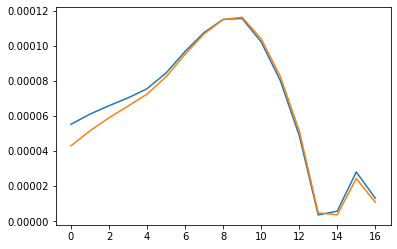

In [121]:
plt.plot(W_ph[100,:,100,100])
plt.plot(W_p[100,:,100,100])

## Buoyancy fluxes plot

Text(0.5, 0.92, 'Run QWA19 1km ERA5 - N100 - CFB+Bulk no TFB - Hed=100')

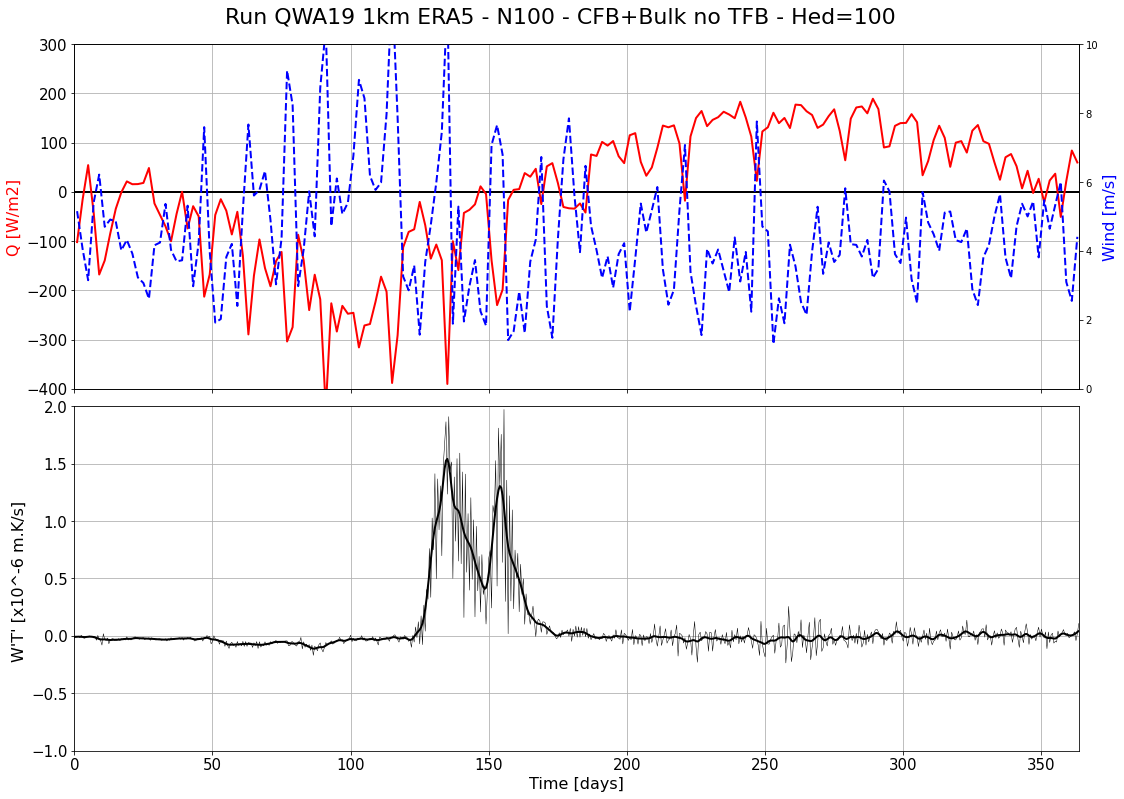

In [9]:
plt.figure(0, figsize=(18,13))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[2,2], wspace=0.1, hspace=0.05)

ax1=plt.subplot(gs[0])    ### Q 
plt.plot([0,time_h[-1]],[0,0],'-k',lw=2)
plt.plot(time_a, Qmean,'-r', lw=2) ; plt.grid()
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.ylim([-400,300])
plt.tick_params(labelsize=15, labelbottom=False)

ax2=ax1.twinx()      ### Wind
ax2.plot(time_a, Wspeed,'--b',lw=2)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time_h[-1]]) ; plt.ylim([0,10])

ax3=plt.subplot(gs[1])
plt.plot(time_h,WT_p_M*1e6,'-k', lw=0.5)  ; plt.grid()
plt.plot(time_h,nd.gaussian_filter1d(WT_p_M*1e6, sigma=2),'-k', lw=2)
plt.xlim([0,time_h[-1]]) ; plt.ylim([-1,2])
plt.ylabel("W'T' [x10^-6 m.K/s] ", size=16)
plt.xlabel('Time [days]', size=16)
plt.tick_params(labelsize=15)

plt.suptitle(str_title, size=22, y=0.92)


### Multiple resolution plot

In [99]:
Q_1=np.load(path_save+'Q_mean_1km.npy')
W_1=np.load(path_save+'W_mean_1km.npy')
WT_1=np.load(path_save+'WT_mean_1km_d300.npy')

Q_2=np.load(path_save+'Q_mean_2km.npy')
W_2=np.load(path_save+'W_mean_2km.npy')
WT_2=np.load(path_save+'WT_mean_2km_d300.npy')

### Warning : time axis might be different for 4km!
Q_4=np.load(path_save+'Q_mean_4km.npy')
W_4=np.load(path_save+'W_mean_4km.npy')
WT_4=np.load(path_save+'WT_mean_4km_d300.npy')

Text(0.5, 0.92, 'Buoyancy fluxes at different resolution (with eddy)')

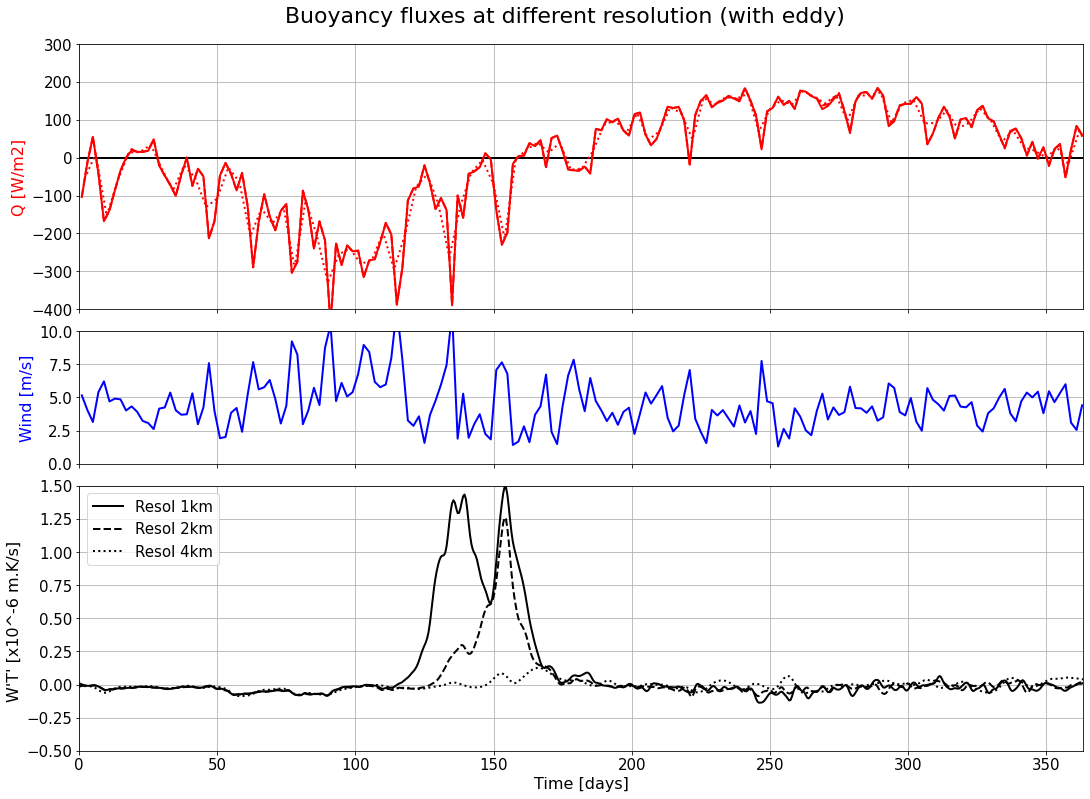

In [113]:
plt.figure(0, figsize=(18,13))
gs = GridSpec(3, 1, width_ratios=[1], height_ratios=[2,1,2], wspace=0.1, hspace=0.1)

ax1=plt.subplot(gs[0])    ### Q 
plt.plot([0,time_h[-1]],[0,0],'-k',lw=2) ; plt.grid()
plt.plot(time_a, Q_1,'-r', lw=2) 
plt.plot(time_a, Q_2,'--r', lw=2)
plt.plot(time_a*2, Q_4,':r', lw=2)
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.ylim([-400,300]) ; plt.xlim([0,time_h[-1]])
plt.tick_params(labelsize=15, labelbottom=False)

ax2=plt.subplot(gs[1])      ### Wind
ax2.plot(time_a, W_1,'-b',lw=2) ; plt.grid()
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time_h[-1]]) ; plt.ylim([0,10])
plt.tick_params(labelsize=15, labelbottom=False)

ax3=plt.subplot(gs[2]) ; plt.grid()
plt.plot(time_h,nd.gaussian_filter1d(WT_1*1e6, sigma=2),'-k', lw=2, label='Resol 1km')
plt.plot(time_h,nd.gaussian_filter1d(WT_2*1e6, sigma=2),'--k', lw=2, label='Resol 2km')
plt.plot(time_h*2,nd.gaussian_filter1d(WT_4*1e6, sigma=2),':k', lw=2, label='Resol 4km')
plt.legend(loc=2, fontsize=15)

plt.xlim([0,time_h[-1]]) ; plt.ylim([-0.5,1.5])
plt.ylabel("W'T' [x10^-6 m.K/s] ", size=16)
plt.xlabel('Time [days]', size=16)
plt.tick_params(labelsize=15)

plt.suptitle('Buoyancy fluxes at different resolution (with eddy)', size=22, y=0.92)

### Saving as .npy

In [90]:
resol='4km'
#np.save(path_save+'WT_mean_'+resol+'_d'+str(depth_m)+'.npy', WT_p_M)
np.save(path_save+'Q_mean_'+resol+'.npy', Qmean.data)
np.save(path_save+'W_mean_'+resol+'.npy', Wspeed.data)


## Loading AMEDA results

In [122]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]
## Syntax : 
#D[D[tracks['shapes1'][Eddy_nb,0]][0][Timestep]][Streamline, X/Y]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :100
Number of eddies :137


In [123]:
#StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
StepEddy=np.zeros((Ned, int(params_dict['stepF'])))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

Text(0.5, 1.0, 'Eddy occurence matrix')

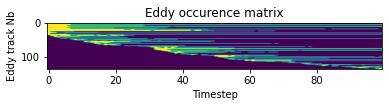

In [124]:
plt.imshow(StepEddy, aspect=1/10) ; plt.xlabel('Timestep') ; plt.ylabel('Eddy track Nb')
plt.title('Eddy occurence matrix')
## np.where(StepEddy[0,:]) #: to have index of first appearance

In [126]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>80) & (Polarity==-1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]

#### MANUAL SELECTION
#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

#MainEddy=np.array([0,168,383]) ### QWA120
#DayEddy=np.array([[0,240],[242,610],[612,720]])

#MainEddy=np.array([0,117]) ### QWA123
#DayEddy=np.array([[0,372],[374,720]])

#MainEddy=np.array([4]) ### QWA121-2

#MainEddy=np.array([15,0]) ### QWA119-3
#DayEddy=np.array([[190,240],[242,380]])

#MainEddy=np.array([43]) ### QWA201-2
#MainEddy=np.array([15]) ### QWA202-2
#MainEddy=np.array([18]) ### QWA206-2
#MainEddy=np.array([32]) ### QWA207-2
#MainEddy=np.array([17]) ### QWA208-2
MainEddy=np.array([33]) ### QWA209-2

Eddy index living more than x timesteps :


### Old version

Text(0, 0.5, 'Days')

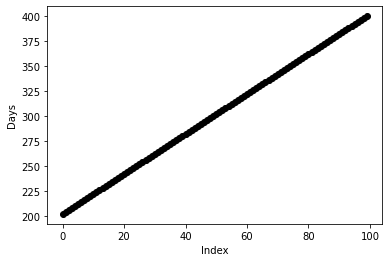

In [127]:
Rmaxed=[] ; Vmaxed=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmaxed+=list(D[tracks['rmax1'][h,0]][0])
    Vmaxed+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(D[tracks['step'][h,0]][0]*timestep+time_h[0])
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

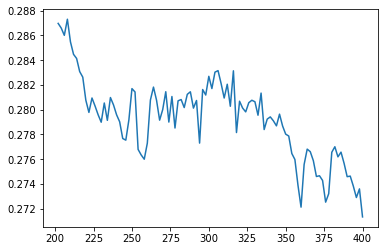

In [128]:
plt.plot(timeeddy,Vmaxed)

## Investigating NIIW

In [70]:
SSTmax=np.max(temp_h[:,-1],axis=(1,2))
SSTmin=np.min(temp_h[:,-1],axis=(1,2))
SSTmean=np.mean(temp_h[:,-1],axis=(1,2))
#plt.plot(SSTmin) ; plt.plot(SSTmax) ; plt.plot(SSTmean)

NameError: name 'temp_h' is not defined

In [71]:
cust=cm.jet ; Ncycl=10
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

In [41]:
len(time_h)
path_save='../Analysis/QWA22_Wanom/'

  0%|          | 0/1617 [00:00<?, ?it/s]<ipython-input-42-34a2bdefafe5>:75: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CP3=plt.pcolor(xi_rho, z_dzt, W_h[t,:,idy]*1e3, cmap=cm.seismic, vmin=Levels_v[0], vmax=Levels_v[-1])
<ipython-input-42-34a2bdefafe5>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  0%|          | 1/1617 [00:01<52:27,  1.95s/it]<ipython-input-42-34a2bdefafe5>:75: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shad

KeyboardInterrupt: 

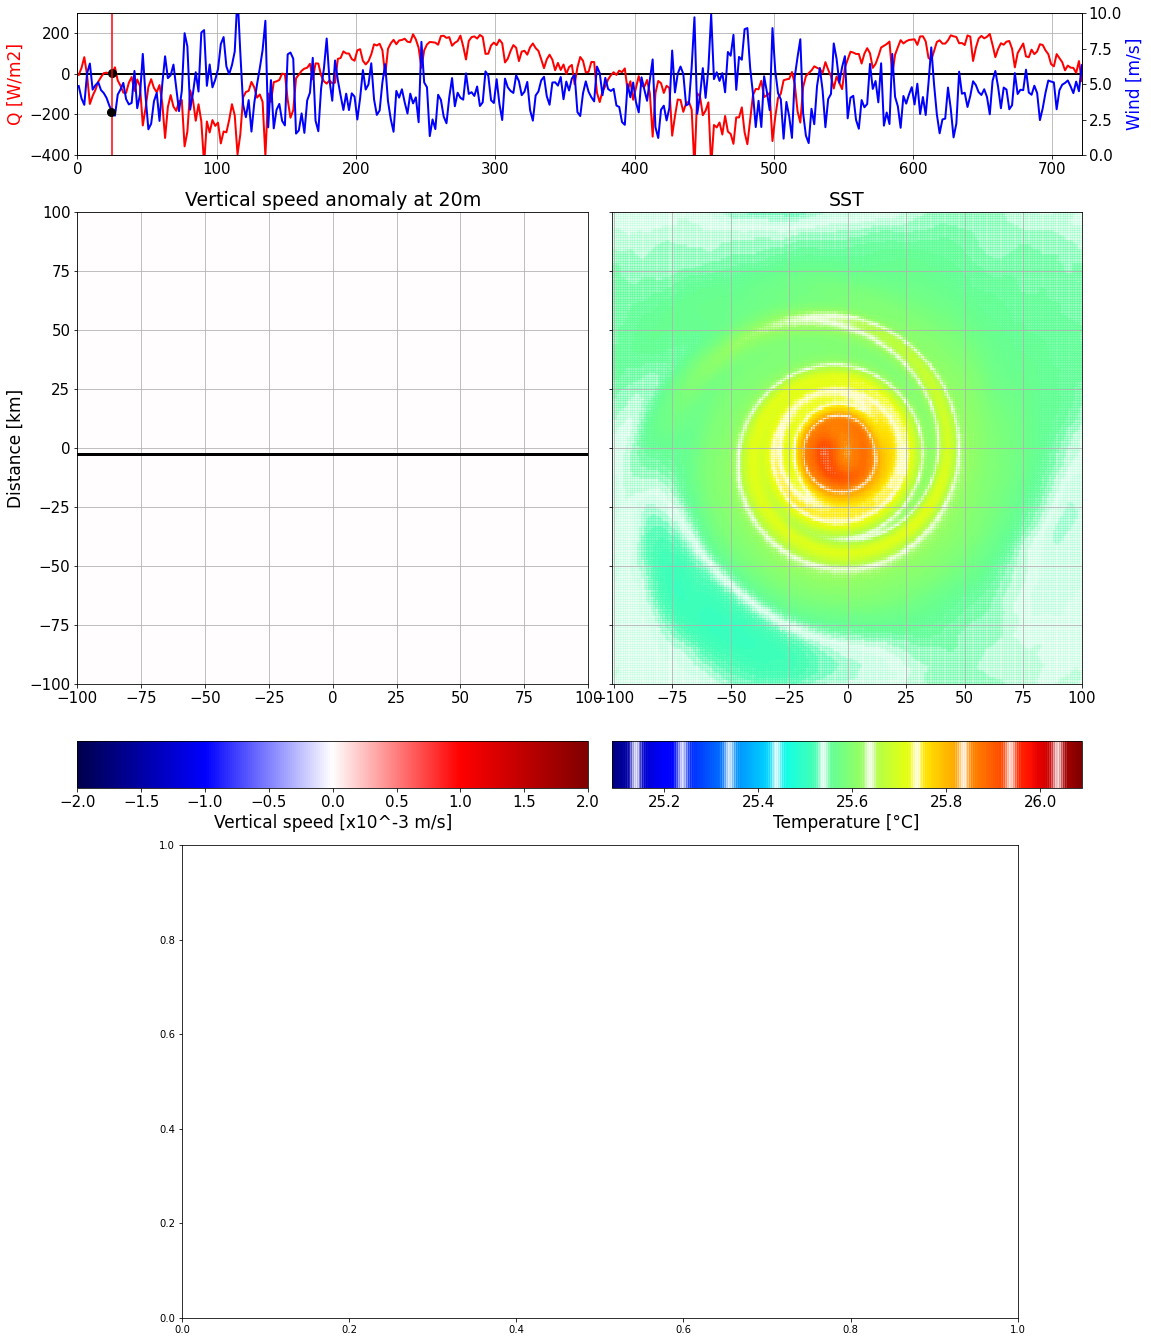

In [42]:
t=1020 ; plot_number=False ; TS=15 ; LS=17 ; Navg=4

for t in tqdm(range(50,len(time_h)-500)):
    ### Takes into consideration if "multiple Main" => takes the first one
    tf=np.argmin(np.abs(time_a-time_h[t]))
    idt0=np.where(timeeddy==time_h[t])[0]
    if len(idt0)>0:
        idt0=idt0[0]
        idy=np.argmin(np.abs(xi_rho-Y1[idt0]))

    SSTticks=np.arange(SSTmean[t]-1.5-(SSTmean[t]-0.5)%1, SSTmean[t]+1.5-(SSTmean[t]-0.5)%1,0.2)
    ### Translating temperature to density
    T0=25 ; R0=26 ; Tcoef=0.28  
    Sigma=R0-Tcoef*(temp_h[t,:,idy]-T0)

    Levels=np.arange(25.5,29.2,0.1)
    Levels_v=np.arange(-2,2.1,0.1)

    plt.figure(0, figsize=(18,24))
    gs = GridSpec(4, 4, width_ratios=[2,10,10,1], height_ratios=[3,10,1,10], wspace=0.1, hspace=0.2)

    plt.subplot(gs[1,:2])  ### Vertical speed anom
    plt.pcolor(x_rho, y_rho, W_p[t,-6]*1e3, cmap=cm.seismic, vmin=-2, vmax=2)
    plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k',lw=3)
    plt.title('Vertical speed anomaly at 20m', size=19); plt.ylabel('Distance [km]',size=LS)
    plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
    plt.tick_params(labelsize=TS)
    CB2=plt.colorbar(cax=plt.subplot(gs[2,:2]), orientation='horizontal')
    CB2.ax.set_xlabel('Vertical speed [x10^-3 m/s]', fontsize=LS) ; CB2.ax.tick_params(labelsize=TS)

    plt.subplot(gs[1,2:])  ### SST
    plt.pcolor(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean[t]-0.5, vmax=SSTmean[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)

    ### Plotting AMEDA eddies
    ListPs=np.where(StepEddy[:,idt0])[0]
    for i in range(len(ListPs)):
        if ListPs[i] in MainEddy:
            lw=5  ## THicker line for Main Eddy
        else:
            lw=2
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==idt0)[0]
        ### Plotting Rmax
        Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
        plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
        if plot_number:
            plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
        ### Plotting Rend
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
    plt.xlim([-Xmax-1,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
    plt.tick_params(labelleft=False,labelsize=TS)
    plt.title('SST', size=19)
    CB1=plt.colorbar(cax=plt.subplot(gs[2,2:]), orientation='horizontal')
    CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=LS)
    CB1.ax.set_xlim([SSTmean[t]-0.5,SSTmean[t]+0.5])
    CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
    CB1.ax.tick_params(labelsize=TS)

    ax1=plt.subplot(gs[0,:])    ### Q 
    plt.plot([0,time_a[-1]],[0,0],'-k',lw=2)
    plt.plot(time_a, Qmean,'-r', lw=2) ; plt.grid()
    plt.plot(time_a[tf], Qmean[tf],'ok', ms=8)
    plt.plot([time_a[tf]]*2, [-500,400],'-r')
    plt.ylabel('Q [W/m2]',size=LS, color='r')
    plt.ylim([-400,300]) ; plt.tick_params(labelsize=TS)

    ax2=ax1.twinx()      ### Wind
    ax2.plot(time_a, Wspeed,'-b',lw=2)
    plt.plot(time_h[t], Wspeed[tf],'ok', ms=8)
    plt.ylabel('Wind [m/s]',size=LS, color='b')
    plt.xlim([0,time_a[-1]]) ; plt.ylim([0,10])
    plt.tick_params(labelsize=TS)

    plt.subplot(gs[3,1:3])  ### Vertical speed Section
    CP3=plt.pcolor(xi_rho, z_dzt, W_h[t,:,idy]*1e3, cmap=cm.seismic, vmin=Levels_v[0], vmax=Levels_v[-1])
    #CP1=plt.pcolor(xi_rho, zvert, Sigma, cmap=cm.Spectral, vmin=Levels[0], vmax=Levels[-1])
    CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
    plt.clabel(CP2, Levels, fmt='%3.1f')
    plt.tick_params(labelsize=TS)
    plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
    plt.ylabel('Depth [m]',size=LS) ; plt.xlabel('Distance [km]',size=LS)
    plt.plot([0,0],[0,0],'-k',lw=2, label='Isopycnals') ; plt.legend(loc=4,fontsize=LS)
    CB2=plt.colorbar(CP3, cax=plt.subplot(gs[3,3]), orientation='vertical')
    CB2.ax.set_ylabel('Vertical speed [x10^-3 m/s]', fontsize=LS) ; CB2.ax.tick_params(labelsize=TS)

    plt.suptitle(str_title+' - t= '+str(time_h[t])+' days', size=18, y=0.91)
    ###
    plt.tight_layout()
    plt.savefig(path_save+'W_section_t='+'{:03.0f}'.format(time_h[t]*10)+'.png')
    plt.close()


In [83]:
### Correcting movie frames order
import imageio
import os
###########
path_save='/home6/datahome/abarboni/CROCO/Analysis/QWA19/'
filelist=os.listdir(path_save)
filelist=np.sort(filelist)
if filelist[0]=='.ipynb_checkpoints':
    filelist=filelist[1:] #to remove '.ipynb_checkpoints'

order=[]
for i in range(len(filelist)):
    order+=[int(float(filelist[i][10:-4])*10)]
file_sort=[x for _,x in sorted(zip(order,filelist))]
file_sort[0]

'W_anomaly=25.0.png'

In [84]:
moviename='QWA19_W_anom'

In [85]:
images = []

for k in tqdm(range(len(file_sort))):
    filename=path_save+file_sort[k]  ###   <========== CHANGE FILENAME HERE #######
    images.append(imageio.imread(filename))
   
imageio.mimwrite(path_save+'../Movies/'+moviename+'.mp4', images, 'MP4', fps=2)#**kargs)   ####  <===== Change movie.mp4 name here


100%|██████████| 696/696 [01:23<00:00,  8.30it/s]


## Following Eddy center

In [129]:
idted=np.where((timeeddy>t_bd_bis[0]*2) & (timeeddy<t_bd_bis[1]*2))[0]  ## Choosing 2nd summer for QWA121-2
xbis=np.array(X1)[idted] ; ybis=np.array(Y1)[idted]
timebis=timeeddy[idted]
indx=np.zeros(len(xbis)) ; indy=np.zeros(len(ybis))

for x in tqdm(range(len(xbis))):
    indx[x]=np.argmin(np.abs(xi_rho-xbis[x])) ; indy[x]=np.argmin(np.abs(xi_rho-ybis[x]))
indx=indx.astype(int) ; indy=indy.astype(int)

100%|██████████| 54/54 [00:00<00:00, 3487.45it/s]


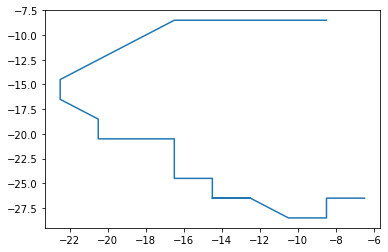

In [130]:
plt.plot(xbis,ybis)

100%|██████████| 54/54 [00:00<00:00, 6553.79it/s]


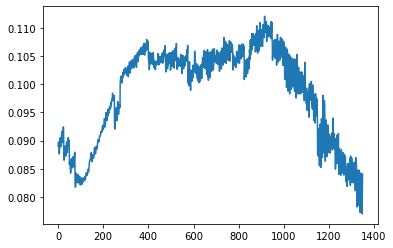

In [131]:
InnerW=np.zeros((len(xbis)*Navg,Nvert))
InnerZeta=np.zeros(len(xbis)*Navg)
for x in tqdm(range(len(xbis))):
    for j in range(Navg):
        InnerW[x*Navg+j,:]=W_p[x*Navg+j,:,indy[x],indx[x]]
        InnerZeta[x*Navg+j]=zeta[x*Navg+j,indy[x],indx[x]]
    ### Checking following Zeta max
plt.plot(InnerZeta)

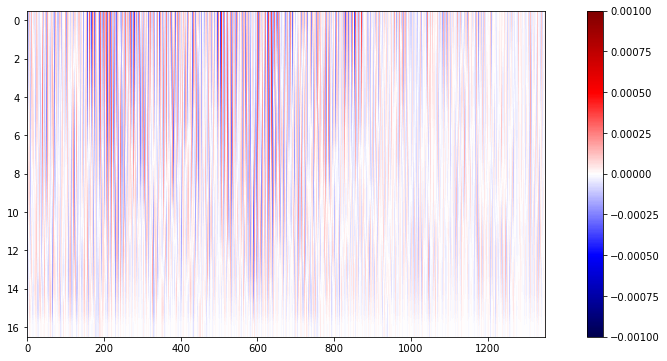

In [132]:
plt.figure(figsize=(15,6))
plt.imshow(InnerW.T,aspect=50,vmin=-1e-3,vmax=1e-3, cmap=cm.seismic)
plt.colorbar()

## Blanking Eddy / Outside-Eddy (Babiano-Sadourny-Basdevant-Legras)

In [133]:
xlist=np.reshape(x_rho,len(x_rho)**2) ; ylist=np.reshape(y_rho,len(x_rho)**2)
#xpsilist=np.reshape(x_psi,len(x_psi)**2) ; ypsilist=np.reshape(y_psi,len(x_psi)**2)
pts=np.array([xlist,ylist]).T #; ptspsi=np.array([xpsilist,ypsilist]).T

In [134]:
steps_ameda=((time_pa-time_a[0])/2).astype(int) ## Choosing 2nd summer for QWA121-2
steps_ameda

masked_array(data=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27,
                   28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                   42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
                   56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=999999)

In [135]:
#### Warning modified version for Navg=50  and time selection
MaskEnd=np.zeros((len(time_pa), Nx,Nx))      ### mask in time_avg !
for j,t in enumerate(tqdm(steps_ameda)):
    ListPs=np.where(StepEddy[:,t])[0]
    ### Mask removing all eddies
    for i in range(len(ListPs)):
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]## Rmax or Rend : 'shapes1' or 'shapes3'
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho))
        MaskEnd[j]+=Inside 

100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


In [136]:
#### Warning modified version for Navg=50  and time selection
MaskMain=np.zeros((len(time_pa), Nx, Nx)) 

for ide,h in enumerate(tqdm(MainEddy)):
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]
    ided=np.where((steps>=t_bd_bis[0]*2) & (steps<=t_bd_bis[1]*2))[0]
    for idbis in ided :
        Contour=D[D[tracks['shapes1'][h,0]][0][idbis]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ### RHO GRID
        MaskMain[idbis-ided[0]-1]+=Inside
        
MaskMain=MaskMain.astype(bool) ; MaskEnd=MaskEnd.astype(bool) ;

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Text(0.5, 1.0, 'Masking all eddies')

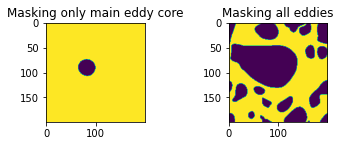

In [137]:
t=45  ## Check
plt.subplot(221) ; plt.imshow(~MaskMain[t]) ; plt.title('Masking only main eddy core')
plt.subplot(222) ; plt.imshow(~MaskEnd[t]) ; plt.title('Masking all eddies')

100%|██████████| 55/55 [00:00<00:00, 305.14it/s]


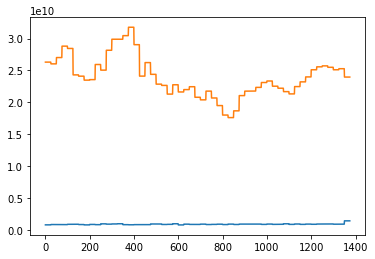

In [138]:
AreaMain=np.zeros(len(time_ph))  ## Area in m2 over Nid time vector
AreaOut=np.zeros(len(time_ph))
for t in tqdm(range(len(time_pa))):
    for i in range(Navg):
        AreaMain[t*Navg+i]=np.sum(MaskMain[t])*dx*dx
        AreaOut[t*Navg+i]=np.sum(~MaskEnd[t])*dx*dx
plt.plot(AreaMain)
plt.plot(AreaOut)

In [139]:
### Data from HIS
WEddy_p=np.copy(W_p) ; WOut_p=np.copy(W_p) #starts at t_bd_ter[0]

for t in tqdm(range(len(time_pa))):
    if np.any(MaskMain[t]):
        for z in range(Nvert):
            for k in range(Navg):  ### Data from HIS
                WEddy_p[t*Navg+k,z][~MaskMain[t]]=0
    else:
        WEddy_p[t]=0
#### MaskEnd
    if np.any(MaskEnd[t]):
        for z in range(Nvert):
            for k in range(Navg):  ### Data from HIS
                WOut_p[t*Navg+k,z][MaskEnd[t]]=0
    else:
        WOut_p[t]=0


100%|██████████| 55/55 [00:03<00:00, 18.25it/s]


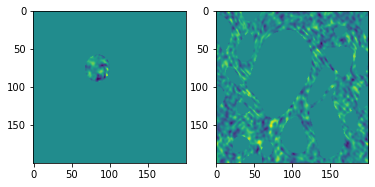

In [140]:
plt.subplot(121)
plt.imshow(WEddy_p[10*50,5])
plt.subplot(122)
plt.imshow(WOut_p[10*50,5])

# Spectral analysis

### 1D Inner W

1.7320508075688772

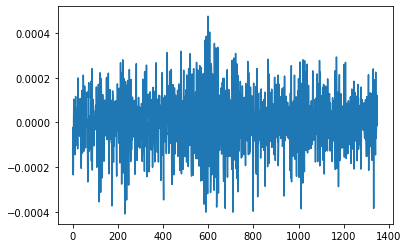

In [144]:
depth=20
idz=np.argmin(np.abs(zvert+depth))
#plt.plot(W_h[120,:,100,100],zvert)
plt.plot(InnerW[:,idz])
f=2*np.sin(np.pi/180*60.0)
f  ## in day-1

In [145]:
omega=np.fft.rfftfreq(len(timebis)*Navg,2/Navg)
W_omega=np.fft.rfft(InnerW[:,idz])
#W_omega=np.fft.rfft(W_p[:,idz,100,100])

(0.0, 7.0)

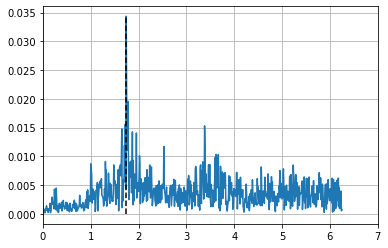

In [146]:
plt.plot(omega, np.abs(W_omega))
plt.grid()
plt.plot([f,f],[0,np.max(np.abs(W_omega))],'--k')
plt.xticks(np.arange(13))
plt.xlim([0,7])
#plt.yscale('log')

## Multidimensional FFT

### Test 2D uniquement

In [147]:
W_omk=np.fft.fftn(W_p[:,idz,100,:],axes=(0,1))
k_freqR=np.fft.rfftfreq(Nx,dx/1000)  ## real wavenumber vector!
omega=np.fft.fftfreq(Nid,2/Navg)  ## in  day-1  !
omegaR=omega[:int(Nid/2)]

In [148]:
np.shape(W_omk)#, len(k_freqR), len(omegaR),Ns

(1375, 200)

### Summing negative omega/k 

In [149]:
W_ok_R=np.zeros((len(omegaR),len(k_freqR)))
for j in tqdm(range(len(k_freqR))):
                #omegaR)):
    if j==0: ### for zero freq
        for i in range(1,len(omegaR)): 
            W_ok_R[i,j]=1/2*(np.abs(W_omk[i,j]**2)+np.abs(W_omk[Nid-i,j]**2))
        #    if j==0:
        #        W_ok_R[i,j]=np.abs(W_omk[i,j]**2)
         #   else:
    else:
        for i in range(1,len(omegaR)): 
            W_ok_R[i,j]=1/4*(np.abs(W_omk[i,j]**2)+np.abs(W_omk[Nid-i,j]**2)+np.abs(W_omk[i,Nx-j]**2)+np.abs(W_omk[Nid-i,Nx-j]**2))

100%|██████████| 101/101 [00:00<00:00, 125.25it/s]


Text(0, 0.5, 'Energy density [m^2.s^-2/cpkm/cpd]')

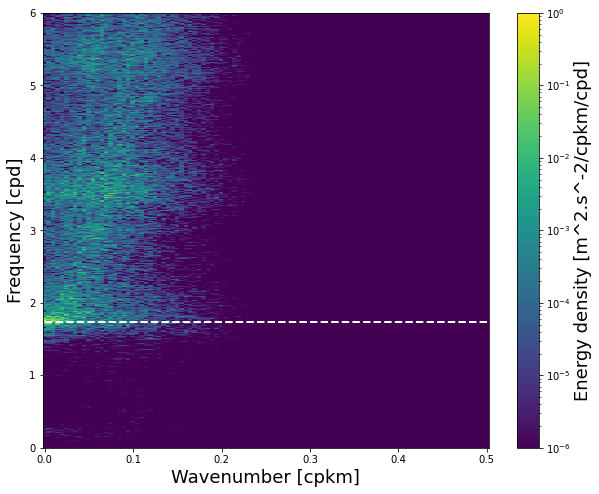

In [150]:
plt.figure(0, figsize=(10,8))
plt.pcolor(k_freqR,omegaR,np.abs(W_ok_R[:,:101]**2),norm=col.LogNorm(vmin=1e-6, vmax=1e0))
plt.plot([0,0.5],[f,f],'--w',lw=2)
plt.ylim([0,6])
plt.xlabel('Wavenumber [cpkm]',size=18)
plt.ylabel('Frequency [cpd]',size=18)
CB=plt.colorbar()
CB.ax.set_ylabel('Energy density [m^2.s^-2/cpkm/cpd]',size=18)

## 3D FFT

In [151]:
#k_1d=np.fft.fftshift(np.fft.fftfreq(Nx,dx/1000))  ## x and y wavenumbers in cpkm
#l_1d=np.fft.fftshift(np.fft.fftfreq(Nx,dx/1000))  ## x and y wavenumbers in cpkm
k_1d=np.fft.fftfreq(Nx,dx/1000)  ## x and y wavenumbers in cpkm
l_1d=np.fft.fftfreq(Nx,dx/1000)  ## x and y wavenumbers in cpkm
k_freqR=np.fft.rfftfreq(Nx,dx/1000)

#k_h=np.fft.rfftfreq(int(Nx*np.sqrt(2)),dx/1000/np.sqrt(2)) ## possible values for 2D wavenumber
#k_h=np.fft.rfftfreq(Nx,dx/1000) ## possible values for 2D wavenumber

omega=np.fft.fftfreq(Nid,2/Navg)  ## in  day-1  !
omegaR=omega[:int(Nid/2)]

dk=np.diff(k_1d)[0]
domega=np.diff(omega)[0]

k_2d,l_2d=np.meshgrid(k_1d,l_1d)
Kh=np.sqrt(k_2d**2+l_2d**2)    ## 2D wavenb matrix
dk=np.diff(k_1d)[0]  ## Spectral resolution => La prendre variable pour tenir compte pixelisation cercle ?

In [152]:
W2_okl=np.abs(np.fft.fftn(W_p[:,idz,:,:],axes=(0,1,2))**2)
W2eddy_okl=np.abs(np.fft.fftn(WEddy_p[:,idz,:,:],axes=(0,1,2))**2)
W2out_okl=np.abs(np.fft.fftn(WOut_p[:,idz,:,:],axes=(0,1,2))**2)

## Normalisation

In [153]:
DT=time_ph[-1]-time_ph[0]
KEtot=np.sum(W_p[:,idz,:,:]**2)/Nx/dx/Nx/dx/Nid  ###  vertical energy in m2/s2/m2 in real space
KEtot

1.0884130956194015e-14

In [154]:
AreaMain

array([7.770e+08, 7.770e+08, 7.770e+08, ..., 1.406e+09, 1.406e+09,
       1.406e+09])

In [155]:
KEeddy=np.nansum(np.nansum(WEddy_p[:,idz,:,:]**2,axis=(1,2))/AreaMain)/Nid
KEout=np.nansum(np.nansum(WOut_p[:,idz,:,:]**2,axis=(1,2))/AreaOut)/Nid
KEeddy, KEout ### Total vertical energy in m2/s2/m2 for inside / Outside-eddy

(1.8468288382821236e-14, 1.0368380472602801e-14)

In [156]:
np.sum(W2_okl/len(k_1d)/len(k_1d)/len(omega))/Nx/dx/Nx/dx/Nid ### vertical energy in m2/s2/m2 in Fourier space

1.0884130956193993e-14

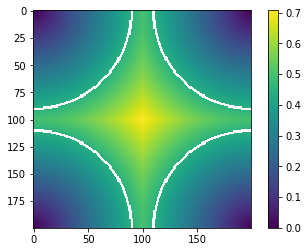

In [157]:
Kh_m=np.copy(Kh)  ### Checking wavenumber "circle"
i=90
k=k_freqR[i]
Kh_m[(Kh>k-dk/2) & (Kh<k+dk/2)]=np.nan
plt.imshow(Kh_m)  ; plt.colorbar()
#np.abs(W_omkl[20][(Kh>k-dk/2) & (Kh<k+dk/2)])

### Isotropisation

In [158]:
W2_oK=np.zeros((Nid,len(k_freqR)))
W2eddy_oK=np.zeros((Nid,len(k_freqR)))
W2out_oK=np.zeros((Nid,len(k_freqR)))

for j,k in enumerate(tqdm(k_freqR)):
    for i in range(Nid):
        W2_oK[i,j]=np.sum(W2_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])
        W2eddy_oK[i,j]=np.sum(W2eddy_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])
        W2out_oK[i,j]=np.sum(W2out_okl[i][(Kh>k-dk/2) & (Kh<k+dk/2)])

100%|██████████| 101/101 [00:29<00:00,  3.38it/s]


(1375, 101)

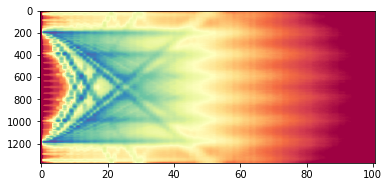

In [159]:
plt.imshow(W2_oK, aspect=1/30,cmap = cm.Spectral, norm=col.LogNorm(vmin=0.1, vmax=1e4))
np.shape(W2_oK)

## Summing  negative/positive frequencies

In [160]:
W2_ok_R=np.zeros((len(omegaR),len(k_freqR)))
W2eddy_ok_R=np.zeros((len(omegaR),len(k_freqR)))
W2out_ok_R=np.zeros((len(omegaR),len(k_freqR)))

for i in tqdm(range(len(omegaR))):
    if i==0: ### for zero freq
        W2_ok_R[i,:]=W2_oK[i,:]
        W2eddy_ok_R[i,:]=W2eddy_oK[i,:]
        W2out_ok_R[i,:]=W2out_oK[i,:]
    else:
        W2_ok_R[i,:]=0.5*(W2_oK[i,:]+W2_oK[Nid-i,:])
        W2eddy_ok_R[i,:]=0.5*(W2eddy_oK[i,:]+W2eddy_oK[Nid-i,:])
        W2out_ok_R[i,:]=W2out_oK[i,:]

100%|██████████| 687/687 [00:00<00:00, 86799.62it/s]


## Plots

In [161]:
path_save='/home6/datahome/abarboni/CROCO/Analysis/'

In [162]:
#np.min(W2_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/dx/Nx/dx/Nx)
zeta0=2*0.28*np.exp(1/1.6)/28e3
zeta0*86400/2/np.pi

feff=f-zeta0*86400/2/np.pi/2  ## f_eff = f + zeta/2 # /2 cf  is important cf Danioux 2015
feff

1.4751485472810917

Text(0.5, 1.0, 'vert speed spectrum at z=20m - dx=1km')

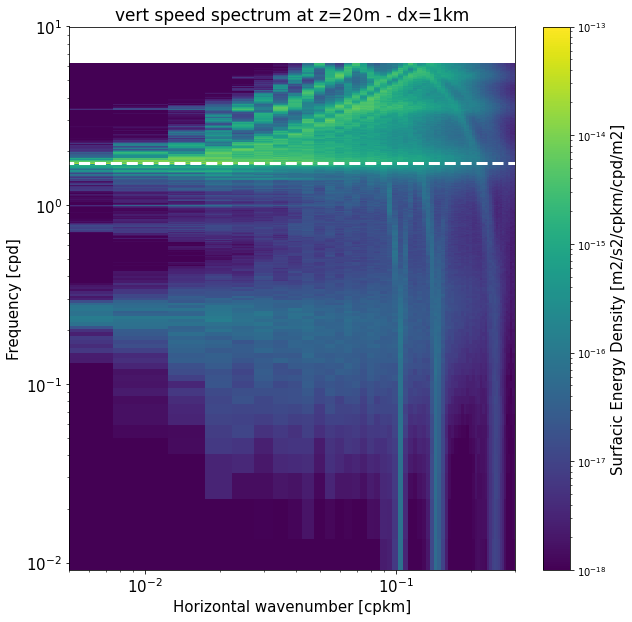

In [163]:
plt.figure(0, figsize=(10,10))                      #### TOTAL Field
plt.pcolor(k_freqR,omegaR,W2_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/dx/Nx/dx/Nx,norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=15)
plt.ylabel('Frequency [cpd]', size=15)
plt.tick_params(labelsize=15)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],10])
plt.title('vert speed spectrum at z='+str(depth)+'m - dx=1km',size=17)
#plt.savefig(path_save+'E_omegaK_tot_loglog.png')

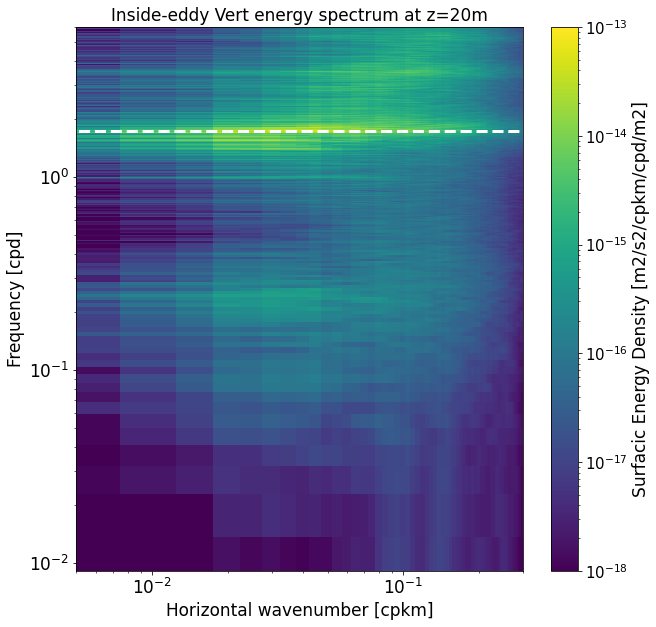

In [164]:
plt.figure(0, figsize=(10,10))                      #### Inside-Eddy
plt.pcolor(k_freqR,omegaR,W2eddy_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/np.mean(AreaMain),norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=17)
CB.ax.tick_params(labelsize=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=17)
plt.ylabel('Frequency [cpd]', size=17)
plt.tick_params(labelsize=17)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],6])
plt.title('Inside-eddy Vert energy spectrum at z='+str(depth)+'m',size=17)
plt.savefig(path_save+'E_omegaK_eddy_loglog_'+expname.upper()[:6]+'.png')

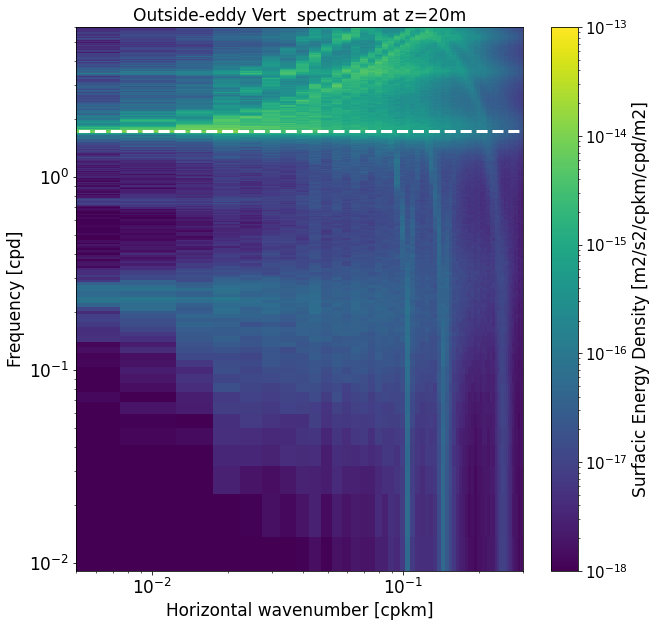

In [165]:
plt.figure(0, figsize=(10,10))                      ### OUTSIDE EDDY
plt.pcolor(k_freqR,omegaR,W2out_ok_R/len(k_1d)/len(k_1d)/len(omegaR)/np.mean(AreaOut),norm=col.LogNorm(vmin=1e-18, vmax=1e-13))
plt.plot([0,1],[f,f],'--w',lw=3)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=17)
CB.ax.tick_params(labelsize=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=17)
plt.ylabel('Frequency [cpd]', size=17)
plt.tick_params(labelsize=17)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],6])
plt.title('Outside-eddy Vert  spectrum at z='+str(depth)+'m',size=17)
plt.savefig(path_save+'E_omegaK_out_loglog_'+expname.upper()[:6]+'.png')

## Saving .npy

In [166]:
DW2={}
DW2['W2out_ok_R']=W2out_ok_R
DW2['W2eddy_ok_R']=W2eddy_ok_R
DW2['k_freqR']=k_freqR
DW2['omegaR']=omegaR
DW2['f']=f ; DW2['feff']=feff
DW2['AreaMain']=AreaMain
DW2['AreaOut']=AreaOut
DW2['KEeddy']=KEeddy ; DW2['KEout']=KEout
np.save(path_save+'W2_Fourier3D_'+expname.upper()+'_'+str(depth)+'m.npy', DW2)

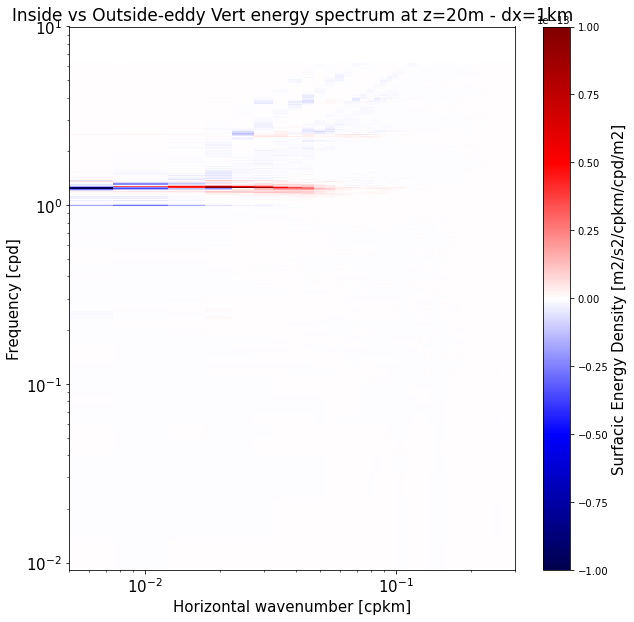

In [52]:
plt.figure(0, figsize=(10,10))
#plt.pcolor(k_freqR,omegaR,W2_ok_R,norm=col.LogNorm(vmin=1e-3, vmax=3e4))
plt.pcolor(k_freqR,omegaR,(W2eddy_ok_R/np.mean(AreaMain)-W2_ok_R/np.mean(AreaOut))/len(k_1d)/len(k_1d)/len(omega), cmap=cm.seismic, vmin=-1e-13, vmax=1e-13)
plt.xscale('log') ; plt.yscale('log')
CB=plt.colorbar()
CB.ax.set_ylabel('Surfacic Energy Density [m2/s2/cpkm/cpd/m2]', size=15)
plt.xlabel('Horizontal wavenumber [cpkm]',size=15)
plt.ylabel('Frequency [cpd]', size=15)
plt.tick_params(labelsize=15)
plt.xlim([k_freqR[1],0.3]);plt.ylim([omegaR[1],10])
plt.title('Inside vs Outside-eddy Vert energy spectrum at z='+str(depth)+'m - dx=1km',size=17)
plt.savefig(path_save+'E_omegaK_diff_loglog.png')